In [17]:
import numpy as np
import pandas as pd
import random 
import torch
import regex as re
from nltk.corpus import stopwords
from collections import Counter

from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer 
from collections import OrderedDict
from nltk.corpus import stopwords

from torch import nn
from torch.functional import F
from torch import optim
from tqdm import tqdm

import time

In [18]:
remove_stopwords = True
use_lemmatization = True
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"\w+")
catchedStopWords = stopwords.words('english')

In [19]:
def tokenize_doc(sent,
                 lemma=False, 
                 remove_stopwords=False):
    
    # a simple tokenizer with case folding and an option to use lemmatization
    sent = sent.lower()
    tokens = sent.split()
    tokens = [*Counter(tokens).keys()]
    
    if lemma:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    if remove_stopwords:
        tokens = [token for token in tokens if token not in catchedStopWords]
    return tokens

def basic_text_processing(corpus, num_words):
    vocab = set()
    all_tokens = []
    
    # tokenization
    for doc in tqdm(corpus):
        tokens = tokenize_doc(doc, lemma=use_lemmatization, remove_stopwords=remove_stopwords)
        vocab.update(set(tokens))
        all_tokens.extend(tokens)
    print("Tokenization complete")

    freq_words = dict(Counter(all_tokens).most_common(num_words))
    train_tokens = [token for token in all_tokens if token in freq_words]
    
    # generating vocabulary from the train_tokens
    word_counts = Counter(train_tokens)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) 
    i2w = {ii: word for ii, word in enumerate(sorted_vocab)}
    w2i = {word: ii for ii, word in i2w.items()}
    
    return  w2i, i2w, train_tokens

In [20]:
def get_contexts(words, idx):
    contexts = [words[idx-2], words[idx-1], words[idx+1], words[idx+2]]
    return contexts

In [21]:
def get_batches(words, batch_size):  #, window_size = 4):
    for i in range(0, len(words), batch_size):
        curr = words[i:i + batch_size]   # current batch
        batch_x, batch_y = [], []
        #batch = []
        for ii in range(2,len(curr)-2):
            x = get_contexts(curr, ii)
            y = curr[ii]
            #batch.append((x,y))
            batch_x.append(x)
            batch_y.append(y)
        
        yield batch_x, batch_y
        #yield batch

In [22]:
#CC-e woNews dataset contains news articles from news sites all over thrld. 
#The data is available on AWS S3 in the Common Crawl bucket at /crawl-data/CC-NEWS/. 
#This version of the dataset has been prepared using news-please - an integrated web crawler and information extractor for news.
#It contains 708241 English language news articles published between Jan 2017 and December 2019. 
#It represents a small portion of the English language subset of the CC-News dataset.

from datasets import load_dataset
dataset = load_dataset("cc_news")
corpus = dataset['train']['text'][:150000]


Found cached dataset cc_news (/home/nhatvan1561/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/ae469e556251e6e7e20a789f93803c7de19d0c4311b6854ab072fecb4e401bd6)


  0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# all configurations go here
n_vocab = 10000  # maximum size of vocab
n_embed = 50 # size of embedding
lr = 0.0005 # learning rate
n_negative_samples = 5 # number negative examples per positive example
ws = 5  # window size
batch_size =  50 # batch size for sampling positive examples
n_epochs =  5 #umber of training epochs
device = 'cpu'

In [24]:
w2i, i2w, train_tokens = basic_text_processing(corpus, num_words=n_vocab)
int_words = [w2i[token] for token in train_tokens]
print("Vocab Size:", len(w2i))

100%|█████████████████████████████████| 150000/150000 [02:02<00:00, 1222.57it/s]


Tokenization complete
Vocab Size: 10000


### Training

In [9]:
def train_cbow(    w1,
                   w2,
                   int_words,
                   n_vocab,
                   n_embed,
                   learning_rate,
                   n_negative_samples,
                   batch_size,
                   n_epochs,
                   print_every=100):
    
    optimizer = optim.Adam([w1, w2], lr=learning_rate)    
    w1 = torch.nn.init.uniform_(w1, -0.10, +0.10)
    w2 = torch.nn.init.uniform_(w2, -0.10, +0.10)

    step = 0
    
    for epoch in range(n_epochs):
        for inputs, targets in get_batches(int_words, batch_size=batch_size):
            step += 1

            contexts_indices = torch.LongTensor(inputs).to(device) # number_batches x window_size
            targets_indices = torch.LongTensor(targets).to(device) # number_batches x label
            b_size = contexts_indices.shape[0]
            
            # feedward
            c_embed = w1[contexts_indices].mean(1).view(b_size, n_embed,1)
            
            # retrieve vectors of negative examples and negative targets words
            noise_dist = torch.ones((b_size,n_vocab))
            noise_words = torch.multinomial(noise_dist, 
                                            num_samples=n_negative_samples, 
                                            replacement=True)
            noise_words = noise_words.to(device)
            nt_embed = w2[noise_words]
            
            # retrieve vectors of targets words and positive context words
            pt_embed = w2[targets_indices].view([b_size, 1, n_embed])
            neg_loss = torch.bmm(nt_embed.neg(),c_embed).sigmoid().log().sum(1).squeeze()
            pos_loss = torch.bmm(pt_embed,c_embed).sigmoid().log().squeeze()

            # Negative sampling loss
            loss = (pos_loss + neg_loss).neg().mean()
            # optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (step % print_every) == 0:
                print("Epoch: {}/{} | Loss: {:.4f}".format(epoch+1, n_epochs, loss.item()))

                



In [27]:
# initialization of W and C weight matrix
w1 = torch.nn.Parameter(torch.zeros((n_vocab, n_embed), dtype=torch.float32))
w2 = torch.nn.Parameter(torch.zeros((n_vocab, n_embed), dtype=torch.float32))

In [158]:
train_cbow(    w1,
               w2,
               int_words,
               n_vocab=n_vocab,
               n_embed=n_embed,
               learning_rate=lr,
               n_negative_samples=n_negative_samples,
               batch_size=batch_size,
               n_epochs=n_epochs,
               print_every=10000)

Epoch: 1/5 | Loss: 2.1561
Epoch: 1/5 | Loss: 2.0632
Epoch: 1/5 | Loss: 2.0341
Epoch: 1/5 | Loss: 2.3297
Epoch: 1/5 | Loss: 1.9913
Epoch: 1/5 | Loss: 1.4548
Epoch: 1/5 | Loss: 2.1695
Epoch: 1/5 | Loss: 1.9682
Epoch: 1/5 | Loss: 1.3937
Epoch: 1/5 | Loss: 2.1737
Epoch: 1/5 | Loss: 1.9278
Epoch: 1/5 | Loss: 2.0779
Epoch: 1/5 | Loss: 2.1182
Epoch: 1/5 | Loss: 2.0860
Epoch: 1/5 | Loss: 1.7078
Epoch: 1/5 | Loss: 1.8256
Epoch: 1/5 | Loss: 1.7015
Epoch: 1/5 | Loss: 1.8982
Epoch: 1/5 | Loss: 2.0030
Epoch: 1/5 | Loss: 2.2102
Epoch: 1/5 | Loss: 1.8746
Epoch: 1/5 | Loss: 1.8713
Epoch: 1/5 | Loss: 1.7386
Epoch: 1/5 | Loss: 1.1607
Epoch: 1/5 | Loss: 1.2169
Epoch: 1/5 | Loss: 1.6159
Epoch: 1/5 | Loss: 1.7637
Epoch: 1/5 | Loss: 2.1385
Epoch: 1/5 | Loss: 1.4732
Epoch: 1/5 | Loss: 2.0113
Epoch: 1/5 | Loss: 2.0150
Epoch: 1/5 | Loss: 1.3606
Epoch: 1/5 | Loss: 2.1799
Epoch: 1/5 | Loss: 1.6042
Epoch: 1/5 | Loss: 1.7937
Epoch: 1/5 | Loss: 1.9401
Epoch: 2/5 | Loss: 1.6467
Epoch: 2/5 | Loss: 0.7614
Epoch: 2/5 |

### Evaluation via Visualization

/home/nhatvan1561/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nhatvan1561/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


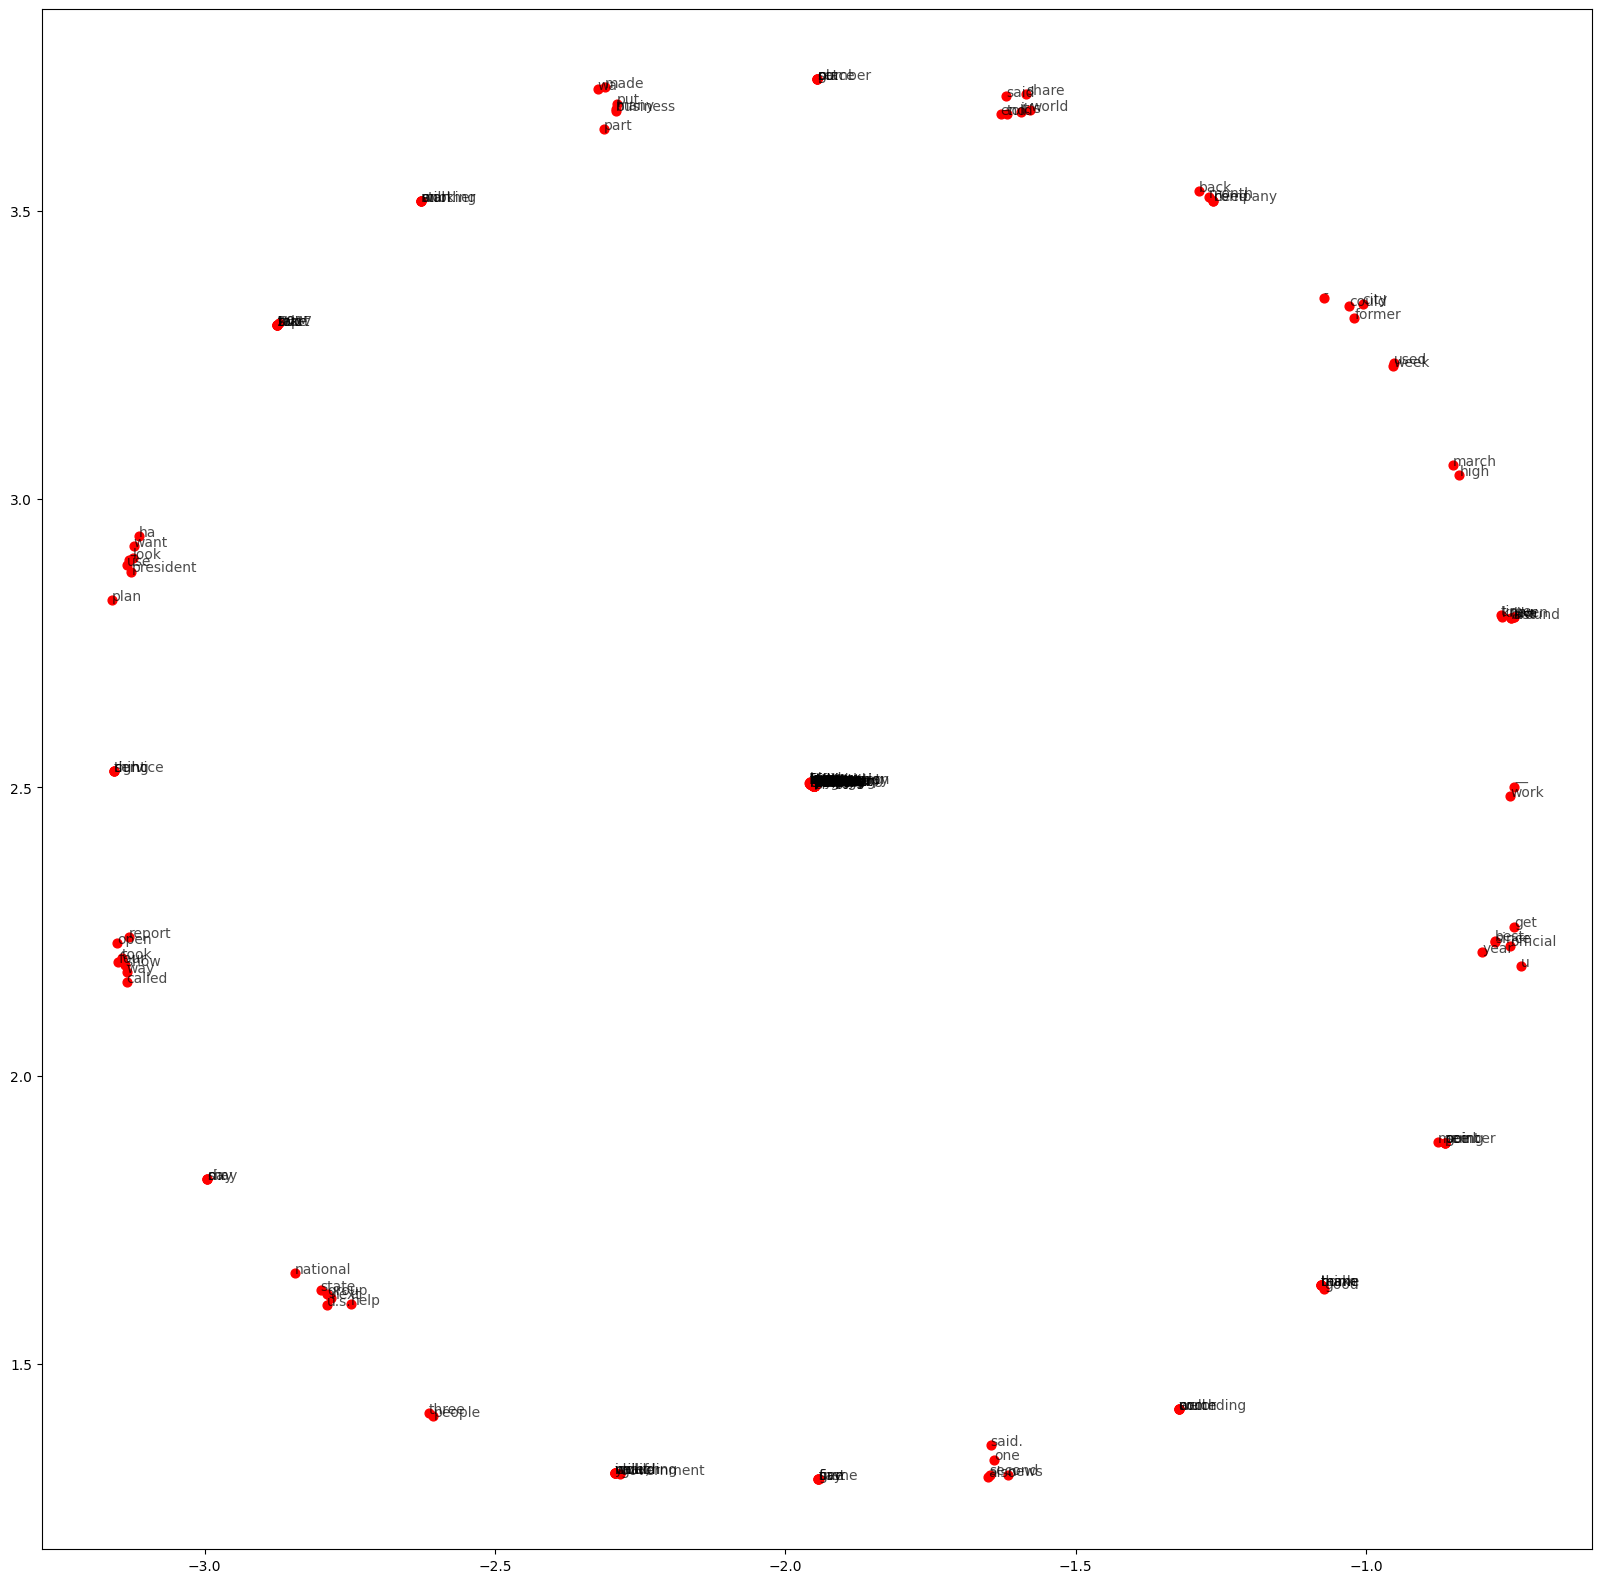

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_viz_words = 200
tsne = TSNE()
embeddings_tsne = tsne.fit_transform(embeddings[:n_viz_words, :])

fig, ax = plt.subplots(figsize = (20, 20))
for i in range(n_viz_words):
    plt.scatter(*embeddings_tsne[i, :], color = 'red', s=40)
    plt.annotate(i2w[i], (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), alpha = 0.7)

### Evaluation via Document Similarity

In [42]:
def transform(query, w2i, embeddings, strategy):
    # input: query or document, vocabulary w2i
    # input: trained word2vec embeddings
    # input: strategy: either 'average' or 'concatenate'
    # output: vector representation of the document query
    w2v_query = tokenize_doc(query, lemma=use_lemmatization, remove_stopwords=remove_stopwords)
    idx = [w2i[word] for word in w2v_query if word in w2i]
    v = [embeddings[i] for i in idx]
    assert strategy in ['average', 'concatenate']
    
    # get vectors of each word in the query
    
    # sentence aggregation strategy
    if strategy == 'average':
        # TODO START
        vector = [em.mean() for em in v]
        # vector = 
        # TODO END
    else:
        # TODO START
        vector = np.ravel(v)
        # TODO END
    
    return vector

In [39]:
# test document similarity
q = transform('today I am very happy', w2i, embeddings, strategy='concatenate')
v = transform('today I feel so fascinated', w2i, embeddings, strategy='concatenate')
sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
print("Cosine Similarity: {}".format(sim)) # this score should be high / close to 1.0

Cosine Similarity: nan


/tmp/ipykernel_5056/3363197586.py:4: RuntimeWarning: invalid value encountered in float_scalars
  sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))


In [48]:
def evaluation(strategy):
    df = pd.read_csv('./quora_train.csv')
    print("Loaded {} pairs".format(len(df)))
    pairs = list(zip(df['question1'].astype(str), df['question2'].astype(str)))
    
    all_sims = []
    
    for doc1, doc2 in tqdm(pairs):
        q = transform(doc1, w2i, embeddings, strategy=strategy)
        v = transform(doc2, w2i, embeddings, strategy=strategy)
        if (q == []) or (v==[]):
            continue
        diff = len(q) - len(v)
        if diff > 0:
            v = np.pad(v, (0, np.abs(diff)))
        else:
            q = np.pad(q, (0, np.abs(diff)))
        
        sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
        all_sims.append(sim)
        
    return np.mean(all_sims)

In [49]:
avg_similarity = evaluation('average')
print("Final Average Similarity using Average Strategy: {}".format(avg_similarity))

Loaded 13000 pairs


  0%|                                                 | 0/13000 [00:00<?, ?it/s]/tmp/ipykernel_5056/1467545404.py:19: RuntimeWarning: invalid value encountered in double_scalars
  sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
100%|███████████████████████████████████| 13000/13000 [00:03<00:00, 3952.19it/s]

Final Average Similarity using Average Strategy: nan


In [ ]:
avg_similarity = evaluation('concatenate')
print("Final Average Similarity using Concatenation Strategy: {}".format(avg_similarity))